### Anomalies by Message Passing (AMP) code
Author: Varun Chandola (All Rights Reserved)
Contact: chandola@buffalo.edu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as sp
from math import sqrt
from scipy.stats import multivariate_normal as mvn
import pickle
import mpld3
from scipy.stats import pearsonr
import time
from sklearn import manifold
%run DataGenerator.ipynb 
%matplotlib inline

ERROR: File `u'DataGenerator.ipynb.py'` not found.


## ITERATIVE ANOMALY DETECTION ALGORITHM - June 7 2016
** Quality function **
- Q1 - tightest ROI
- Q2 - homogeneous ROI
- Q3 - ?

** Initialization function **
- V1 - Start with only $M_{ii} = 1$
    - V1.1 - Introduce an epsilon threshold
- V2 - Start with all $M_{ij} = 1$
- V3 - Randomly assign some $M_{ij} = 1$


In [4]:
datasets = pickle.load(open('datasets.pickle','r'))

In [9]:
# try amp1
for i in range(1,2):
    data,labels = datasets[i]
    D = sp.distance.pdist(data)
    D = sp.distance.squareform(D)
    S = np.exp(-D)

In [6]:
# create small data sets
S = np.array([[1,0.8,0.8,0.1],[0.8,1,0.8,0.1],[0.8,0.8,1,0.1],[0.1,0.1,0.1,1]])

In [7]:
S = np.array([[1.00,0.95,0.95,0.50,0.05,0.05,0.05],
              [0.95,1.00,0.95,0.50,0.05,0.05,0.05],
              [0.95,0.95,1.00,0.50,0.05,0.05,0.05],
              [0.50,0.50,0.50,1.0,0.50,0.50,0.50],
              [0.05,0.05,0.05,0.50,1.00,0.95,0.95],
              [0.05,0.05,0.05,0.50,0.95,1.00,0.95],
              [0.05,0.05,0.05,0.50,0.95,0.95,1.00]])

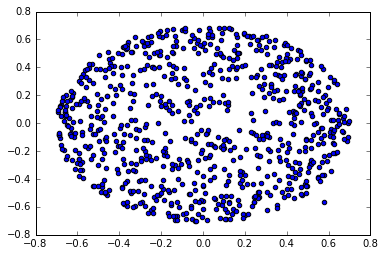

In [10]:
mds = manifold.MDS(dissimilarity='precomputed')
y = mds.fit_transform(1-S)
plt.scatter(y[:,0],y[:,1])

In [11]:
def quality(m,s,opt='tight'):
    '''
    computes the quality of a region of influence.
    quality is equal to the similarity with the farthest object in its ROI
    '''
    if opt not in ['tight','uniform','filled']:
        raise ValueError('Unsupported option')
    
    if opt == 'tight':
        return np.min(s[m > 0])
    elif opt == 'uniform':
        return 1- np.std(s[m > 0])
    elif opt == 'filled':
        return np.min(s[m > 0])/np.sum(m)

In [12]:
def qualitydiff(m,s,j,opt='tight'):
    '''
    compute the difference in the quality of ROI after 'flipping' the bit in m[j]
    '''
    m1 = m.copy()
    m1[j] = np.abs(m[j]-1)
    return quality(m1,s,opt=opt) - quality(m,s,opt=opt)

In [13]:
def initM(N,opt='diag',p=0.1,S=[]):
    '''
    initialize M matrix
    '''
    if opt not in ['diag','all','rand','randone','near','far']:
        raise ValueError('Unsupported option')
    
    if opt == 'diag':
        M = np.eye(N)
    elif opt == 'all':
        M = np.ones([N,N])
    elif opt == 'rand':
        m = np.zeros([N*N])
        t = int(np.round(p*N*N))
        m[0:t] = 1
        np.random.shuffle(m)
        M = np.reshape(m,[N,N])
    elif opt == 'randone':
        M = np.zeros([N,N])
        for i in range(N):
            ri = (i + np.random.randint(N)+1)%N
            M[i,ri] = 1
    elif opt == 'near':
        M = np.zeros([N,N])
        if len(S) == 0 or S.shape != (N,N):
            raise ValueError('This option requires a (N x N) similarity matrix')
        np.fill_diagonal(S,-float("inf")*np.ones([N,1]))
        mS = np.argmax(S,axis=1)
        for i in range(N): 
            M[i,mS[i]] = 1
        np.fill_diagonal(S,np.ones([N,1]))
    elif opt == 'far':
        M = np.zeros([N,N])
        if len(S) == 0 or S.shape != (N,N):
            raise ValueError('This option requires a (N x N) similarity matrix')
        mS = np.argmin(S,axis=1)
        for i in range(N): 
            M[i,mS[i]] = 1
    else:
        raise ValueError('Unsupported option')
    return M

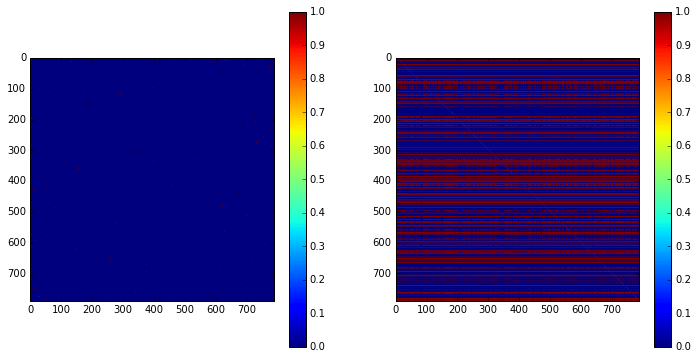

In [14]:
## INPUTS - S (matrix of similarities), Q (function for computing quality of ROI)
## STEP 1 - Initialize M
N = S.shape[0]
Minit = initM(N,'near',p=0.25,S=S)
M = Minit.copy()
np.fill_diagonal(M,np.ones([N,1]))
qualityfunc = 'filled'
for iters in range(25):
    ## STEP 2 - Each object computes quality of its ROI
    q = np.zeros([N,])
    for i in range(N):
        q[i] = quality(M[i,:],S[i,:],opt=qualityfunc)
    ## STEP 3 - Each object computes the delta for every other object
    delta = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            if i != j:
                delta[i,j] = np.sum(M[:,i])*qualitydiff(M[i,:],S[i,:],j,opt=qualityfunc) + pow(-1,M[i,j])*q[j]
    ## STEP 4 - Each object updates its ROI
    for i in range(N):
        for j in range(N):
            if delta[i,j] > 0:
                M[i,j] = np.abs(M[i,j] - 1)
    ## GOTO Step 2
## DONE
fig = plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.imshow(Minit)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(M)
plt.colorbar()

In [ ]:
fig = plt.figure(figsize=[8,8])
cmap=plt.colormaps()[33] 
rho = np.sum(M,axis=0)
#scatter = plt.scatter(data[:,0],data[:,1],alpha=0.5,c=labels,s=s,cmap=cmap)
scatter = plt.scatter(data[:,0],data[:,1],alpha=0.5,c=labels,cmap=cmap)
labels1 = ['%d - %f'%(i,rho[i]) for i in range(N)]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels1)
mpld3.plugins.connect(fig, tooltip)
mpld3.display()

In [ ]:
from tempfile import NamedTemporaryFile
from matplotlib import animation
from IPython.display import HTML

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim,fps):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=fps, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)


def display_animation(anim,fps=10):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim,fps))

In [ ]:
def amp1(D,eps=0.1,maxiters=10,alpha=1):

    N = D.shape[0]
    # INITIALIZATION
    D1 = D.copy()
    np.fill_diagonal(D1,float("inf")*np.ones([N,1]))
    mu = np.zeros([N,1])
    sigma = np.ones([N,1])

    rho = np.zeros([N,1])
    E = np.zeros([N,N])
    A = np.zeros([N,N])
    scores = []
    rhos = []
    # ITERATIVE PHASE
    for iters in range(maxiters):
        rhos.append(rho)
        '''
        compute E[i,j]
        E[i,j] is a message from i to j to indicate the willingness of i to be included in the ROI of j
        '''
        E = np.zeros([N,N])
        mu_ = np.tile(mu,[1,N])
        sigma_ = np.tile(sigma,[1,N])
        irho_ = 1 - np.tile(rho,[1,N])
        msg1 = np.abs(mu_ - D)/sigma_
        E = np.exp(-alpha*D)*np.exp(-alpha*msg1)    
        np.fill_diagonal(E,np.zeros([N,1]))
        E = E*irho_

        '''
        Update mu[j] and sigma[j] using E[i,j] for all i. 
        '''
        sums = np.sum(E,axis=0)
        i_sums = np.where(sums == 0)[0]
        sums[i_sums] = 1

        mu = np.sum(E*D,axis=0)/sums
        mu[i_sums] = eps

        mu_ = np.tile(np.transpose(mu),[N,1])
        D1 = D - mu_
        sigma = np.sqrt(np.sum(E*(D1**2),axis=0))/sums
        sigma[i_sums] = eps
        sigma[sigma == 0.0] = eps

        '''
        compute message A, A[i,j] is a message from xj to xi 
        indicating j's willingness to include i in its ROI
        '''
        A = np.zeros([N,N])
        mu_ = np.tile(mu,[N,1])
        sigma_ = np.tile(sigma,[N,1])
        msg2 = np.abs(mu_ - D)/sigma
        A =  np.exp(-alpha*D)*np.exp(-alpha*msg2)
        np.fill_diagonal(A,np.zeros([N,1]))

        '''
        compute rho[i] - anomaly score of i
        rho_i is computed as the weighted sum of the A[i,j] message coming
        from all x_j's. The weight is the message E[i,j] value that x_i had
        sent to x_j earlier
        '''

        rho = np.sum(A,axis=1)
        rho = np.exp(-alpha*rho[:,np.newaxis])
        
        mu = mu[:,np.newaxis]
        sigma = sigma[:,np.newaxis]
    # append the final solution
    rhos.append(rho)
    return rho,rhos,A,mu,sigma

In [ ]:
# try amp1
for i in range(4,5):
    data,labels = datasets[i]
    D = sp.distance.pdist(data)
    D = sp.distance.squareform(D)
    N = data.shape[0]

In [ ]:
alpha = 1
eps = 0.1
rho,rhos,A,mu,sigma = amp1(D,eps=eps,maxiters=20,alpha=alpha)
preds = rho.flatten()
print "%.2f,%.2f"%(precAtK(labels,preds),averageRank(labels,preds))

In [ ]:
fig = plt.figure(figsize=[8,8])
cmap=plt.colormaps()[33] 
if max(rho) > 0:
    s = 120*(rho - min(rho)+np.mean(rho))/max(rho)
    
    scatter = plt.scatter(data[:,0],data[:,1],alpha=0.5,c=labels,s=s,cmap=cmap)
else:
    scatter = plt.scatter(data[:,0],data[:,1],alpha=0.5,c=labels,cmap=cmap)

labels1 = ['%d - %f'%(i,rho[i]) for i in range(N)]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels1)
mpld3.plugins.connect(fig, tooltip)
mpld3.display()

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=[10,8])
ax = fig.gca()
scat = ax.scatter(data[:,0],data[:,1],s=48,alpha=0.6)
# animation function.  This is called sequentially
def init():
    return scat

def animate(i,rhos):
    rho = rhos[i].flatten()
    if max(rho) > 0:
        s = 1 + 200*(rho - min(rho)+np.mean(rho))/max(rho)
    else:
        s = 1 + 200*rho
    scat.set_sizes(s)
    return scat

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,init_func=init,fargs=[rhos],
                               frames=len(rhos), interval=10000, blit=True,repeat=True)
# call our new function to display the animation
display_animation(anim)

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Varun Chandola'), bitrate=1800)
anim.save('/Users/chandola/Research/presentations/upbeat2016_talk/ampdata3.mp4', writer=writer)

In [ ]:
def modify(opt='diag'):
    if opt not in ['diag','all','rand','randone','near','far']:
        raise ValueError('Unsupported option')
    return 1


In [ ]:
# New algorithm
# initialize every object with no coverage (or maybe covering itself)
# at each step, every object evaluates the benefit of including every other item into its ROI
# if the difference in the quality is less than lambda, then include the object